<a href="https://colab.research.google.com/github/mistryvivek/YRKCS-PRBX/blob/main/PADL_Week8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Practical week 8: data loaders and a first CNN

##Set up and dataset

We'll start by loading the MNIST dataset. This comes in the form of the `Dataset` class which can subsequently be passed to the `Dataloader` class to make reading random mini-batches easy.



We're using a few more imports here: torchvision contains many useful operations related specifically to images. It also contains some standard datasets in a prepackaged form. Matplotlib is for displaying images.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

Let's set up the datasets - this will download the dataset to the local (colab) file system.

In [46]:
train_data = datasets.MNIST(root = 'data', train = True, transform = ToTensor(), download = True)
test_data = datasets.MNIST(root = 'data', train = False, transform = ToTensor())

These are `Dataset` objects. They provide two crucial methods. One returns a length so that `len(train_data)` returns the number of elements in the dataset. Second is `__getitem__` which takes the index of data item as input and returns the item (for example, it might return an image and the corresponding label). Later, we will write our own custom dataset.

In [47]:
image, label = train_data.__getitem__(0)
# Or equivalently: image, label = train_data[0]
print(image.shape)
print(label)

torch.Size([1, 28, 28])
5


Datasets can be used with a `Dataloader` as a convenient way to manage requesting random mini-batches and iterating over datasets. The data loader itself is an iterable object that, in this case, returns pairs of input images and corresponding labels of the requested batch size.

In [48]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)

Now that we have a dataset and dataloader, let's take a look at some of the data in our dataset. We'll load a random mini-batch and then display the first 25 images along with their labels.

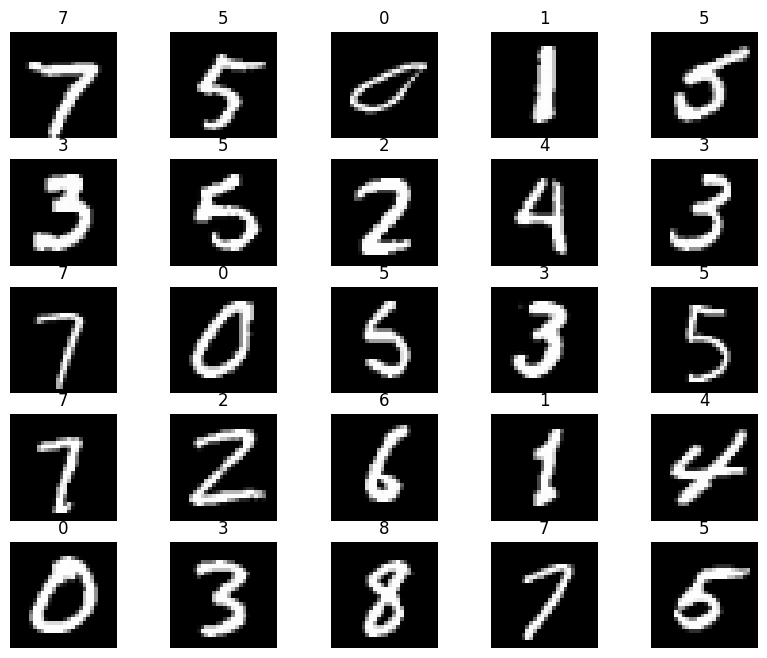

In [7]:
images, labels = next(iter(train_loader))

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.title(labels[i].item())
    plt.axis("off")
    plt.imshow(images[i,:].squeeze(), cmap="gray")
plt.show()

##Defining the network

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.sigmoid = nn.Tanh() # LeCun actually uses hyperbolic tangent, though the paper talks about "sigmoidal function"
        self.meanpool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=5*5*16,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=84)
        self.fc3 = nn.Linear(in_features=84,out_features=10)

    def forward(self, x):
        # Input x has dimensions B x 1 x 28 x 28, B is batch size
        # Comments show tensor size output from previous line
        x = self.conv1(x)
        # B x 6 x 28 x 28
        x = self.sigmoid(x)
        x = self.meanpool(x)
        # B x 6 x 14 x 14
        x = self.conv2(x)
        # B x 16 x 10 x 10
        x = self.sigmoid(x)
        x = self.meanpool(x)
        # B x 16 x 5 x 5
        x = x.view(x.size(0), -1)
        # Flattened to B x 400
        x = self.fc1(x)
        # B x 120
        x = self.sigmoid(x)
        x = self.fc2(x)
        # B x 84
        x = self.sigmoid(x)
        x = self.fc3(x)
        # B x 10
        return x

# Instantiate the model - this initialises all weights and biases
model = LeNet()

##Training

Different to previous practicals, we are using random mini-batches here. This means we have two loops, an outer one over "epochs" (an epoch means every training element has been seen once) and an inner one over random mini-batches as provided by the data loader. This will take a few minutes to run.

In [11]:
num_epochs = 15

optim = torch.optim.SGD(model.parameters(), lr = 0.1)
iterations_per_epoch = len(train_loader)

# Set up the loss function for multiclass classification
loss_func = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
  total_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    output = model(images)
    loss = loss_func(output,labels)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (i+1) % 100 == 0:
       print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
    total_loss += loss
  print('Total loss over epoch {}: {:.2f}'.format(epoch+1,total_loss))

Epoch [1/15], Iteration [100/600], Loss: 0.0399
Epoch [1/15], Iteration [200/600], Loss: 0.0051
Epoch [1/15], Iteration [300/600], Loss: 0.0160
Epoch [1/15], Iteration [400/600], Loss: 0.0110
Epoch [1/15], Iteration [500/600], Loss: 0.0073
Epoch [1/15], Iteration [600/600], Loss: 0.0344
Total loss over epoch 1: 18.26
Epoch [2/15], Iteration [100/600], Loss: 0.0748
Epoch [2/15], Iteration [200/600], Loss: 0.0178
Epoch [2/15], Iteration [300/600], Loss: 0.0325
Epoch [2/15], Iteration [400/600], Loss: 0.0285
Epoch [2/15], Iteration [500/600], Loss: 0.0467
Epoch [2/15], Iteration [600/600], Loss: 0.0361
Total loss over epoch 2: 16.38
Epoch [3/15], Iteration [100/600], Loss: 0.0155
Epoch [3/15], Iteration [200/600], Loss: 0.0096
Epoch [3/15], Iteration [300/600], Loss: 0.0137
Epoch [3/15], Iteration [400/600], Loss: 0.0443
Epoch [3/15], Iteration [500/600], Loss: 0.0106
Epoch [3/15], Iteration [600/600], Loss: 0.0364
Total loss over epoch 3: 15.59
Epoch [4/15], Iteration [100/600], Loss: 0.

Do you think this has converged after 10 epochs? If not, don't run any more for now. See how it performs below then come back and run more if you think performance is still improving.

* Loss is still going down around here - values going up and down which suggests it has not converged.
* Need to check that it is not overfitting.
* 15 epochs - we don't see much of a difference

##Evaluation

Let's see how well it performs on the test set.

In [12]:
correct = 0
total = 0
for images, labels in test_loader:
    output = model(images)
    pred_y = torch.argmax(output, 1)
    correct += (pred_y == labels).sum()
    total += float(labels.size(0))
accuracy = correct/total
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

Test Accuracy of the model on the 10000 test images: 0.99


Pretty amazing huh?! A pretty simple convolutional neural network, a couple of minutes training in your web browser and you can classify 10,000 hand written digits in a few seconds with nearly 100% accuracy! Yann LeCun got to 99.05% test set accuracy with this architecture. You could also get there if you tuned hyperparameters a bit (number of epochs, learning rate, batch size, what optimiser you use).

But before you try to improve it, let's see some examples that it is classifying. This code will display 25 images from the test set, the true label and the classification predicted by your trained network. Each time you run the following code block you'll get results from a new batch. So run it a few times. You should see a few impressive results where it does well on hard examples but also look out for mistakes. Can you guess why it failed on that input?

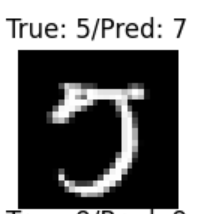

* Look at the corner and the two lines connecting it.

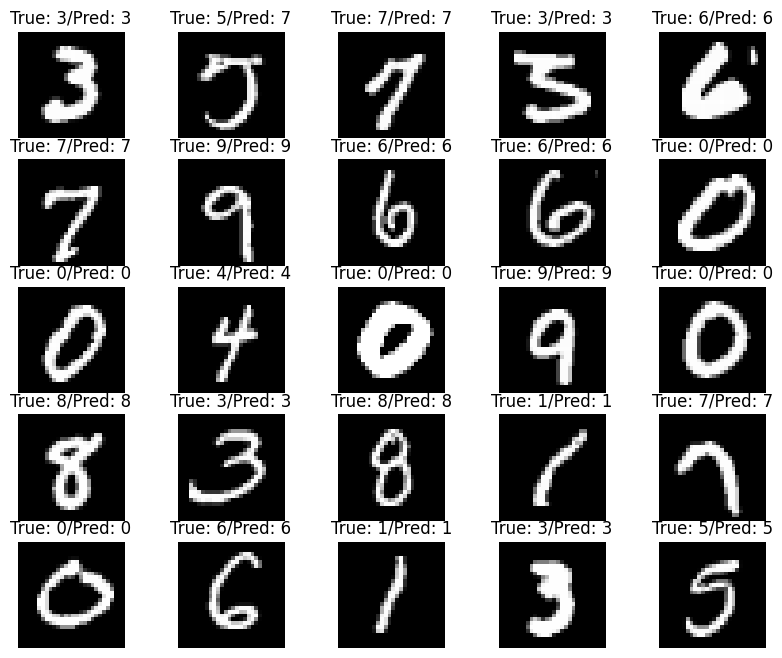

In [23]:
# Run a test batch through the network
images, labels = next(iter(test_loader))
output = model(images)
pred_y = torch.argmax(output, 1)

# Display first 25 images with predicted labels
figure = plt.figure(figsize=(10, 8))
for i in range(25):
    figure.add_subplot(5, 5, i+1)
    plt.title("True: {}/Pred: {}".format(labels[i].item(),pred_y[i].item()))
    plt.axis("off")
    plt.imshow(images[i,:].squeeze(), cmap="gray")
plt.show()

##Visualising the learnt filters

The first convolution layer in the model learns six single channel $5\times 5$ filters. Let's visualise them to see what they've learnt.

**To do**:

Extract the learnt filters from the conv1 layer of model. Display them as grayscale images.

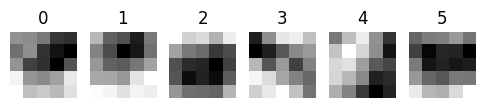

In [31]:
figure = plt.figure(figsize=(6, 1))
for i in range(6):
    figure.add_subplot(1, 6, i+1)
    plt.title(i)
    plt.axis("off")
    plt.imshow(model.conv1.weight[i,:].squeeze().detach(), cmap="gray")
plt.show()

##Visualising the feature maps

As data is passed through a CNN, the tensor after each convolutional layer is referred to as a "feature map" as it still has spatial dimensions (i.e. the tensor will have shape $B\times C\times H\times W$, where $B$ is batch size, $C$ is the number of channels output by that layer and $H$ and $W$ are the height and width of the output tensor).

**To do**:

Write some code to visualise the feature maps as gray scale images. i.e. you should be able to specify a layer and channel and then display this as an image. Display a test input image and then explore the feature maps at different layers. Can you get an impression of what features it is learning?

* There is two solutions here:
  * Pass it through the network then visualise step by step
  * Use something called "forward hooks" https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))


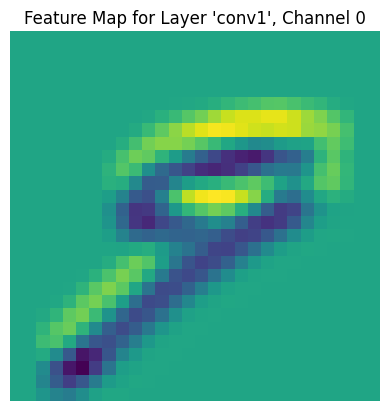

In [36]:
def visualize_feature_map(model, layer_name, channel, input_tensor):
    # Get the specified layer
    layer = None
    # Do a reverse lookup from the module name to the direct module in the class.
    for name, module in model.named_modules():
        if name == layer_name:
            layer = module
            break
    # If its not there, don't do anything.
    if layer is None:
        print(f"Layer '{layer_name}' not found in the model.")
        return

    # Forward pass to get the feature map
    # Hooks to the specified layer.
    activations = None
    def hook(module, input, output):
        nonlocal activations
        activations = output
    hook_handle = layer.register_forward_hook(hook)

    # Dummy input to run forward pass
    # Need to push it through to trigger the hook.
    model.eval()
    with torch.no_grad():
        model(input_tensor)

    # Remove the hook
    # Cleanup
    hook_handle.remove()

    # Get the feature map for the specified channel
    # Output of the layer
    feature_map = activations[:, channel, :, :]

    # Convert to numpy array and plot
    plt.imshow(feature_map.squeeze().cpu(), cmap='viridis')
    plt.title(f"Feature Map for Layer '{layer_name}', Channel {channel}")
    plt.axis('off')
    plt.show()

images, labels = next(iter(train_loader))
input_tensor = images[0,:].unsqueeze(0)
visualize_feature_map(model, 'conv1', 0, input_tensor)


##Digit recognition as a regression problem

The standard way to solve the MNIST digit recognition task is as a classification task, i.e. for an input image, choose one from 10 discrete classes. We will now try to solve the task as a *regression problem*.

**To do**:

The goal is to modify the above model and training code such that the model outputs a single scalar value which should be close to the value of the actual digit. For example, if the input digit has label 4, if the model outputs 4.2, this would be a pretty good answer (and could be rounded to 4). You will need to:

1. Modify the model to have only a single output.
2. Think about the activation/post-processing you will apply to the final output. You know that your digits lie in the range 0 to 9. Can you think of a way to force the network output into this range? (Hint: remember what `torch.nn.sigmoid` does).
3. Modify the loss function. The labels are classes per input image. Your network will now output a continuous scalar value. You want to penalise larger errors more (e.g. predicting 0.4 when the label is 9 is really bad but predicting 4.2 when the label is 5 is not so bad).
4. You may need to tweak hyperparameters like learning rate now that you have a very different loss and network output.
5. Check that training loss reduces during training. Can you compute an accuracy percentage like we did for classification? (Hint: round the output). How does it compare to the classification solution?
6. Modify the code for visualising input images and predicted labels to show the continuous label.

In [39]:
# Labels need converting to floats before you compute the loss.
x = torch.randn(100,1) # output shape
y = torch.randn(100,) # labels shape

print(x.shape)
print(y.shape)
z = x-y
print(z.shape) # can see that it does the wrong thing

torch.Size([100, 1])
torch.Size([100])
torch.Size([100, 100])


In [40]:
class LeNetRegression(nn.Module):
    def __init__(self):
        super(LeNetRegression, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.sigmoid = nn.Tanh() # LeCun actually uses hyperbolic tangent, though the paper talks about "sigmoidal function"
        self.meanpool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=5*5*16,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=84)
        self.fc3 = nn.Linear(in_features=84,out_features=1)

    def forward(self, x):
        # Input x has dimensions B x 1 x 28 x 28, B is batch size
        # Comments show tensor size output from previous line
        x = self.conv1(x)
        # B x 6 x 28 x 28
        x = self.sigmoid(x)
        x = self.meanpool(x)
        # B x 6 x 14 x 14
        x = self.conv2(x)
        # B x 16 x 10 x 10
        x = self.sigmoid(x)
        x = self.meanpool(x)
        # B x 16 x 5 x 5
        x = x.view(x.size(0), -1)
        # Flattened to B x 400
        x = self.fc1(x)
        # B x 120
        x = self.sigmoid(x)
        x = self.fc2(x)
        # B x 84
        x = self.sigmoid(x)
        x = self.fc3(x)
        # B x 1
        x = self.sigmoid(x) # This maps to -1..1
        x = (x+1)*4.5 # After rescaling, the value is now in 0..9
        return x

# Instantiate the model - this initialises all weights and biases
model = LeNetRegression()

In [41]:
num_epochs = 10

optim = torch.optim.SGD(model.parameters(), lr = 0.01)
iterations_per_epoch = len(train_loader)

# Set up the loss function for multiclass classification
loss_func = nn.MSELoss()

for epoch in range(num_epochs):
  total_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    output = model(images)
    loss = loss_func(output,labels.unsqueeze(1).float())
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (i+1) % 100 == 0:
       print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
    total_loss += loss
  print('Total loss over epoch {}: {:.2f}'.format(epoch+1,total_loss))

Epoch [1/10], Iteration [100/600], Loss: 3.6357
Epoch [1/10], Iteration [200/600], Loss: 3.7196
Epoch [1/10], Iteration [300/600], Loss: 4.1135
Epoch [1/10], Iteration [400/600], Loss: 4.4275
Epoch [1/10], Iteration [500/600], Loss: 2.5734
Epoch [1/10], Iteration [600/600], Loss: 1.7020
Total loss over epoch 1: 2024.40
Epoch [2/10], Iteration [100/600], Loss: 1.6150
Epoch [2/10], Iteration [200/600], Loss: 1.5033
Epoch [2/10], Iteration [300/600], Loss: 1.5522
Epoch [2/10], Iteration [400/600], Loss: 2.3189
Epoch [2/10], Iteration [500/600], Loss: 1.2809
Epoch [2/10], Iteration [600/600], Loss: 1.1524
Total loss over epoch 2: 903.93
Epoch [3/10], Iteration [100/600], Loss: 1.0785
Epoch [3/10], Iteration [200/600], Loss: 0.9604
Epoch [3/10], Iteration [300/600], Loss: 0.9646
Epoch [3/10], Iteration [400/600], Loss: 1.4266
Epoch [3/10], Iteration [500/600], Loss: 0.3510
Epoch [3/10], Iteration [600/600], Loss: 0.7332
Total loss over epoch 3: 536.27
Epoch [4/10], Iteration [100/600], Loss

In [42]:
correct = 0
total = 0
for images, labels in test_loader:
    output = model(images)
    pred_y = torch.round(output) # Round the output to get the predicted digit values
    correct += (pred_y == labels.unsqueeze(1)).sum()
    total += float(labels.size(0))
accuracy = correct/total
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

Test Accuracy of the model on the 10000 test images: 0.86


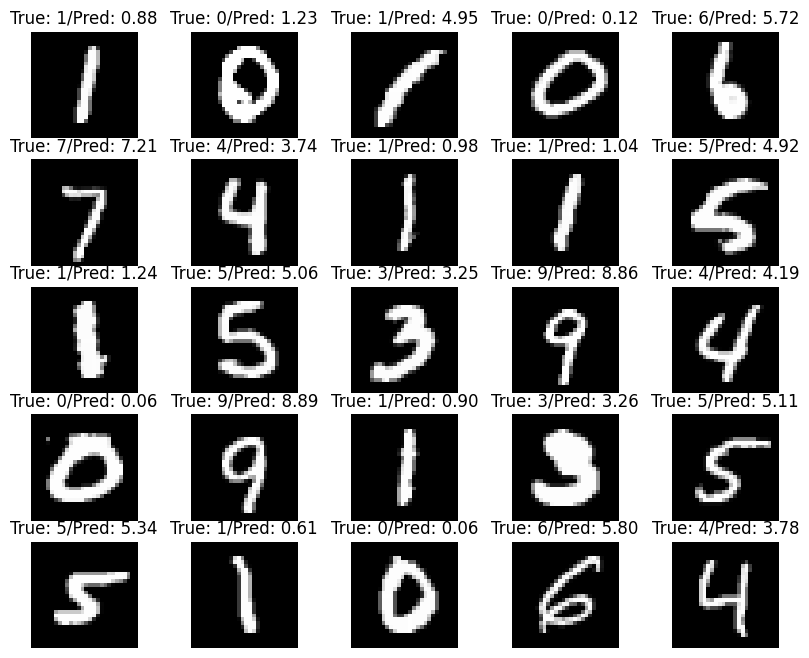

In [43]:
# Run a test batch through the network
images, labels = next(iter(test_loader))
output = model(images)

# Display first 25 images with predicted labels
figure = plt.figure(figsize=(10, 8))
for i in range(25):
    figure.add_subplot(5, 5, i+1)
    plt.title("True: {}/Pred: {:.2f}".format(labels[i].item(),output[i].item()))
    plt.axis("off")
    plt.imshow(images[i,:].squeeze(), cmap="gray")
plt.show()

## Improving the model (highly recommended for Masters-level students)

**To do**:

Now it's time to implement your own alternative model to LeNet (the classification version). I would like you to implement a mini version of the VGG network described in the video lecture. Specifically, aim for more depth (in terms of more convolutional layers) but use $3\times 3$ filters instead of $5\times 5$. Also, use ReLU instead of sigmoid activation and max pooling instead of mean pooling. You can decide how many feature channels to have at each layer. Can you match or improve on the LeNet model performance? Be careful not to add too many parameters overall so that you start overfitting to the training data and making test performance worse.

In [52]:
class miniVGG(nn.Module):
    def __init__(self):
        super(miniVGG, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=0)

        self.fc1 = nn.Linear(in_features=5*5*24,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=84)
        self.fc3 = nn.Linear(in_features=84,out_features=10)

    def forward(self, x):
        # Input x has dimensions B x 1 x 28 x 28, B is batch size
        # Comments show tensor size output from previous line
        x = self.conv1(x)
        # B x 6 x 28 x 28
        x = self.relu(x)
        x = self.maxpool(x)
        # B x 6 x 14 x 14
        x = self.conv2(x)
        # B x 12 x 14 x 14
        x = self.relu(x)
        x = self.maxpool(x)
        # B x 12 x 7 x 7
        x = self.conv3(x)
        # B x 24 x 5 x 5
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        # Flattened to B x 600
        x = self.fc1(x)
        x = self.relu(x)
        # B x 120
        x = self.fc2(x)
        x = self.relu(x)
        # B x 84
        x = self.fc3(x)
        # B x 10
        return x

model = miniVGG()

In [51]:
num_epochs = 15

optim = torch.optim.SGD(model.parameters(), lr = 0.1)
iterations_per_epoch = len(train_loader)

# Set up the loss function for multiclass classification
loss_func = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
  total_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    output = model(images)
    loss = loss_func(output,labels)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (i+1) % 100 == 0:
       print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
    total_loss += loss
  print('Total loss over epoch {}: {:.2f}'.format(epoch+1,total_loss))

Epoch [1/15], Iteration [100/600], Loss: 2.2952
Epoch [1/15], Iteration [200/600], Loss: 2.2764
Epoch [1/15], Iteration [300/600], Loss: 0.7009
Epoch [1/15], Iteration [400/600], Loss: 0.3326
Epoch [1/15], Iteration [500/600], Loss: 0.2726
Epoch [1/15], Iteration [600/600], Loss: 0.1913
Total loss over epoch 1: 718.52
Epoch [2/15], Iteration [100/600], Loss: 0.2057
Epoch [2/15], Iteration [200/600], Loss: 0.2656
Epoch [2/15], Iteration [300/600], Loss: 0.1520
Epoch [2/15], Iteration [400/600], Loss: 0.0659
Epoch [2/15], Iteration [500/600], Loss: 0.0565
Epoch [2/15], Iteration [600/600], Loss: 0.1061
Total loss over epoch 2: 79.88
Epoch [3/15], Iteration [100/600], Loss: 0.0685
Epoch [3/15], Iteration [200/600], Loss: 0.0189
Epoch [3/15], Iteration [300/600], Loss: 0.0349
Epoch [3/15], Iteration [400/600], Loss: 0.0753
Epoch [3/15], Iteration [500/600], Loss: 0.0597
Epoch [3/15], Iteration [600/600], Loss: 0.0989
Total loss over epoch 3: 50.87
Epoch [4/15], Iteration [100/600], Loss: 0

In [55]:
class VGGMine(nn.Module):
    def __init__(self):
        super(VGGMine, self).__init__()

        # First Convolution Block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)  # Reduce padding to keep size.
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions by half.

        # Second Convolution Block
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=9, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Convolution Block
        self.conv5 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        # Adjusting `in_features` based on reduced dimensions after max-pooling layers
        self.fc1 = nn.Linear(in_features=3*3*20, out_features=120)  # Changed to 3x3x20 based on input reduction.
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # First Convolution Block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)

        # Second Convolution Block
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool2(x)

        # Third Convolution Block
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.maxpool3(x)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu1(x)  # Reusing ReLU instance for simplicity
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)

        return x

# Instantiate the model - this initialises all weights and biases
modelMine = VGGMine()

In [59]:
num_epochs = 15

optim = torch.optim.SGD(model.parameters(), lr = 0.1)
iterations_per_epoch = len(train_loader)

# Set up the loss function for multiclass classification
loss_func = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
  total_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    output = modelMine(images)
    loss = loss_func(output,labels)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (i+1) % 100 == 0:
       print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
    total_loss += loss
  print('Total loss over epoch {}: {:.2f}'.format(epoch+1,total_loss))

Epoch [1/15], Iteration [100/600], Loss: 2.3068
Epoch [1/15], Iteration [200/600], Loss: 2.3051
Epoch [1/15], Iteration [300/600], Loss: 2.2968
Epoch [1/15], Iteration [400/600], Loss: 2.3015
Epoch [1/15], Iteration [500/600], Loss: 2.3012
Epoch [1/15], Iteration [600/600], Loss: 2.2998
Total loss over epoch 1: 1381.90
Epoch [2/15], Iteration [100/600], Loss: 2.3180
Epoch [2/15], Iteration [200/600], Loss: 2.2964
Epoch [2/15], Iteration [300/600], Loss: 2.2912
Epoch [2/15], Iteration [400/600], Loss: 2.3216
Epoch [2/15], Iteration [500/600], Loss: 2.2921
Epoch [2/15], Iteration [600/600], Loss: 2.3052
Total loss over epoch 2: 1381.90
Epoch [3/15], Iteration [100/600], Loss: 2.2967
Epoch [3/15], Iteration [200/600], Loss: 2.3205
Epoch [3/15], Iteration [300/600], Loss: 2.3169
Epoch [3/15], Iteration [400/600], Loss: 2.3036
Epoch [3/15], Iteration [500/600], Loss: 2.3076
Epoch [3/15], Iteration [600/600], Loss: 2.2960
Total loss over epoch 3: 1381.90
Epoch [4/15], Iteration [100/600], Lo

KeyboardInterrupt: 

In [64]:
class VGGMine2(nn.Module):
    def __init__(self):
        super(VGGMine2, self).__init__()

        # First Convolution Block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)  # Reduce padding to keep size.
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions by half.

        # Second Convolution Block
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=9, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        # Adjusting `in_features` based on reduced dimensions after max-pooling layers
        self.fc1 = nn.Linear(in_features=7*7*12, out_features=120)  # Changed to 3x3x20 based on input reduction.
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # First Convolution Block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)

        # Second Convolution Block
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool2(x)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu1(x)  # Reusing ReLU instance for simplicity
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)

        return x

# Instantiate the model - this initialises all weights and biases
modelMine2 = VGGMine2()

In [65]:
num_epochs = 15

optim = torch.optim.SGD(model.parameters(), lr = 0.1)
iterations_per_epoch = len(train_loader)

# Set up the loss function for multiclass classification
loss_func = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
  total_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    output = modelMine2(images)
    loss = loss_func(output,labels)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (i+1) % 100 == 0:
       print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
    total_loss += loss
  print('Total loss over epoch {}: {:.2f}'.format(epoch+1,total_loss))

Epoch [1/15], Iteration [100/600], Loss: 2.3049
Epoch [1/15], Iteration [200/600], Loss: 2.3162
Epoch [1/15], Iteration [300/600], Loss: 2.2971
Epoch [1/15], Iteration [400/600], Loss: 2.3148
Epoch [1/15], Iteration [500/600], Loss: 2.3001
Epoch [1/15], Iteration [600/600], Loss: 2.2987
Total loss over epoch 1: 1384.14
Epoch [2/15], Iteration [100/600], Loss: 2.3050
Epoch [2/15], Iteration [200/600], Loss: 2.3202
Epoch [2/15], Iteration [300/600], Loss: 2.3030
Epoch [2/15], Iteration [400/600], Loss: 2.3043
Epoch [2/15], Iteration [500/600], Loss: 2.3019
Epoch [2/15], Iteration [600/600], Loss: 2.3166
Total loss over epoch 2: 1384.14
Epoch [3/15], Iteration [100/600], Loss: 2.3033
Epoch [3/15], Iteration [200/600], Loss: 2.3084
Epoch [3/15], Iteration [300/600], Loss: 2.2901
Epoch [3/15], Iteration [400/600], Loss: 2.3221
Epoch [3/15], Iteration [500/600], Loss: 2.3035


KeyboardInterrupt: 

* The deeper networks I created are necessarily better because it introduces problems such as vanishing gradients and data may become overfitted.
* Sometimes with network like this it is just worth killing rather then wasting more computing power.